Basic simulation
----------------
The `grizli` extraction and fitting code can work as a spectrum simulator, indeed spectrum "simulation" goes hand-in-hand with fitting. Though here we consider "simulation" in the sense of predicting what dispersed spectra would look like for a known direct image and assumed target spectrum in the case of, e.g., observation planning.

In [1]:
# for notebook
%matplotlib inline

## Changes to my system, not the notebook:
 
### This notebook accesses source_properties in photutils which has been deprecated and removed. 
I installed an old photutils build to fix this. \
git clone https://github.com/astropy/photutils \
cd photutils \
git checkout 9a1c1e9 <-- checkout final 1.3 commit: https://github.com/astropy/photutils/commits/1.3.0/ \
pip install . <-- install photutils=1.3 to use deprecated source_properties in Grizli (deleted on next commit) \

### Download this file, put it in the templates folder (this may not be neccesary on a new install):
git clone https://raw.githubusercontent.com/gbrammer/grizli/master/grizli/data/templates/erb2010.dat <--You need this file \
GRIZLI/data/template/erb2010.dat <-- Put it here \
mv ./erb2010.dat ~/GRIZLI/data/template

### Create a symlink (or mv/cp the file):
find ~ -type f -name wfc3_ir_secondary_001_syn.fits (I added 2>/Dev/null to hide "not permitted" errors)\
mkdir -p ~/GRIZLI/comp/wfc3 \
cd ~/GRIZLI/comp/wfc3 \
ln -s -iw -v [insert result from find --> ~/GRIZLI/cdbs/grp/redcat/trds/comp/wfc3/wfc3_ir_secondary_001_syn.fits] 

### Create another optional symlink (or mv/cp):
To resolve a non-fatal warning, I symlinked extinction files \
find ~ -type d -name extinction 2>/dev/null  <-- Note: I had three sets of extinction files (one for every environment with Grizli), I don't know if you get different files for installing the [jwst] vs [hst] dependecies

cd ~/GRIZLI/cdbs \
ln -s -iw -v [insert your favorite find result --> ~/miniconda3/envs/stenv/lib/python3.12/site-packages/pysynphot/test/data/cdbs/extinction]


#### TODO
Learn why the actual exposures look like that (they don't look like that when I use my load_fits, and implot functions; what's different about theirs)\
Maybe: Replace depricate source_properties use \

Ignore, the warning exist in the static notebook on gh: Examine/resolve runetime warnings for overflow and invalid values in multiply/divide \

In [2]:
import os
from astroquery.mast import Observations
import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
#mpl.rcParams['figure.figsize'] = (10.0, 6.18)
mpl.rcParams['figure.figsize'] = (8.0, 4.94)

import numpy as np

import astropy.io.fits as pyfits

import grizli
import grizli.model

In [3]:
if not os.path.exists("mastDownload/HST/ibhj30c4q/ibhj30c4q_flt.fits"):
    obs = Observations.query_criteria(obs_collection='hst', filters="f140w", obs_id='ibhj3*')
    prod = Observations.get_product_list(obs[0])
    im = prod[prod['productSubGroupDescription']=='FLT'][1]
    download = Observations.download_products(im)
    astroquery_obs = download['Local Path'][0]
else:
    astroquery_obs = "mastDownload/HST/ibhj30c4q/ibhj30c4q_flt.fits"

In [4]:
# Files downloaded in examples/Grizli\ Demo.ipynb and put in /tmp/
# Commented out line below, stay in basic-sim dir where the files exist
# os.chdir('/Users/keith/astr/research_astr/grizbox')

## Initialize the FLT object with just a *direct* image.
sim_g141 = grizli.model.GrismFLT(grism_file='', direct_file=astroquery_obs, pad=100)

In [5]:
## Make a simple detection catalog + segmentation image with photutils.
sim_g141.photutils_detection(detect_thresh=0.5, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)

./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt: photutils.detect_sources (detect_thresh=0.5, grow_seg=5, gauss_fwhm=2.0, ZP=26.5)
./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt: photutils.source_properties
Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt: photutils.source_properties - 3 objects
./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt: save ./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt.detect_seg.fits, ./mastDownload/HST/ibhj30c4q/ibhj30c4q_flt.detect.cat


        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


True

In [6]:
## Compute the full grism model.
#sim_g141.compute_full_model(compute_beams=['A','B','C','D'], verbose=False)

keep = sim_g141.catalog['mag'] < 26
c = sim_g141.catalog

sim_g141.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep])

# for id_i, mag_i in zip(sim_g141.catalog['id'][keep], sim_g141.catalog['mag'][keep]):
#     sim_g141.compute_model_orders(id=id_i, compute_size=True, mag=mag_i)

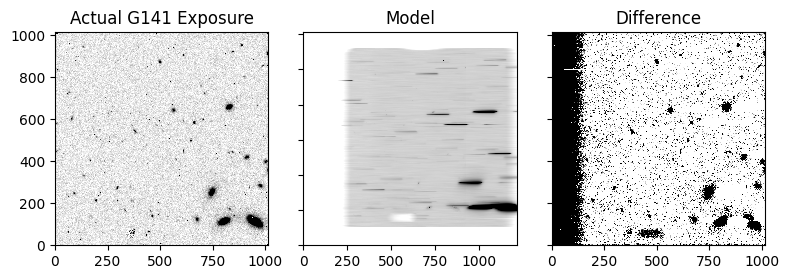

In [7]:
# Compare to the actual G141 exposure
g141 = pyfits.open(astroquery_obs)    
fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(g141['SCI'].data, interpolation='Nearest', 
           origin='lower', vmin=0.5, vmax=2, cmap='gray_r')
ax.set_title("Actual G141 Exposure")

ax = fig.add_subplot(132)
ax.imshow(sim_g141.model, interpolation='Nearest', 
           origin='lower', vmin=0.5, vmax=2, cmap='gray_r')
ax.set_title("Model")

ax = fig.add_subplot(133)
ax.imshow(g141['SCI'].data - sim_g141.model[sim_g141.pad[0]:-sim_g141.pad[0], sim_g141.pad[0]:-sim_g141.pad[0]], 
          interpolation='Nearest', origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title("Difference")

for ax in fig.axes[1:]:
    ax.set_yticklabels([])
    
fig.tight_layout()

In [8]:
# Raising a generic exception so I can "Run all" and stop here automatically.
raise Exception("I haven't made anything past this functional, yet.")

Exception: I haven't made anything past this functional, yet.

In [ ]:
## Now simulate a g102 spectrum
sim_g102 = grizli.model.GrismFLT(grism_file='', direct_file=astroquery_obs, 
                                 force_grism='G102', pad=100)

In [ ]:
# Load segmentation image and catalog we just made
sim_g102.load_photutils_detection()
#sim_g102.compute_full_model(compute_beams=['A','B','C','D'], verbose=False)
keep = sim_g102.catalog['mag'] < 26
for id_i, mag_i in zip(sim_g102.catalog['id'][keep], sim_g102.catalog['mag'][keep]):
    sim_g102.compute_model_orders(id=id_i, compute_size=True, mag=mag_i)

In [ ]:
## Consider an object near the center of the image
dr = np.sqrt(((sim_g141.catalog['x_flt'].value)-sim_g141.pad[0]-579)**2 + ((sim_g141.catalog['y_flt'].value)-sim_g141.pad[0]-522)**2)
ix = np.argmin(dr)
id = sim_g141.catalog['id'][ix]
x0 = sim_g141.catalog['x_flt'].value[ix]+1
y0 = sim_g141.catalog['y_flt'].value[ix]+1
print('id=%d, (x,y)=(%.1f, %.1f)' %(id, x0, y0))

In [ ]:
## Spectrum cutouts
beam_g102 = grizli.model.BeamCutout(sim_g102, sim_g102.object_dispersers[id][2]['A'])
beam_g141 = grizli.model.BeamCutout(sim_g141, sim_g141.object_dispersers[id][2]['A']) 
# beam_g141 = grizli.model.BeamCutout(id=id, x=x0, y=y0, cutout_dimensions=[18,18], 
#                                     conf=sim_g141.conf, GrismFLT=sim_g141)

In [ ]:
# ## Contamination coutouts of spectra around the object of interest
# for beam, sim in zip([beam_g102, beam_g141], [sim_g102, sim_g141]):
#     # flat-spectrum model
#     beam.compute_model(beam.thumb, id=beam.id)  
#     # flat-spectrum model already in sim.model, take it out for the contam cutout
#     beam.contam = beam.get_cutout(sim.model) - beam.model 
plt.imshow(beam_g141.contam, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

In [ ]:
## Example spectrum, low metallicity star-forming galaxy with strong lines
## after the object described by Erb et al. (2010)
spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
erb = np.loadtxt(spectrum_file, unpack=True)
z = 1.0 # test redshift

# show the spectrum and grism passbands
plt.plot(erb[0]*(1+z)/1.e4, erb[1], label='Erb+2010 spectrum', color='0.4')
plt.semilogy()
plt.xlim(0.75,1.75); plt.ylim(4e-4*erb[1].max(),0.5*erb[1].max())
plt.xlabel(r'$\lambda$'); plt.ylabel(r'[arbitrary]')
plt.plot(beam_g102.beam.lam/1.e4, beam_g102.beam.sensitivity, label='G102')
plt.plot(beam_g141.beam.lam/1.e4, beam_g141.beam.sensitivity, label='G141')
plt.legend()

In [ ]:
# Inspired by multimissions-simulation.ipynb cell
# Set PYSYN_CDBS environment variable; Accessed by pysynphot in the next cell
grizli_home = os.getenv("GRIZLI")
os.environ['PYSYN_CDBS'] = f"{grizli_home}/cdbs"
# os.getenv("PYSYN_CDBS")

In [ ]:
S.ArraySpectrum.redshift?

In [ ]:
## Use PySynphot to adjust the flux normalization of the models
import pysynphot as S
spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
# Normalize to AB = 24 in WFC3/IR F160W
ABnorm = 24.0
spec = spec.redshift(z).renorm(ABnorm, 'ABMag', S.ObsBandpass('wfc3,ir,f160w'))
spec.convert('flam') # why is above changing units?

# spec.flux now has units of erg / s / cm2 / A
plt.plot(spec.wave/1.e4, spec.flux)
plt.semilogy()
plt.xlim(0.75,1.75); plt.ylim(4e-4*spec.flux.max(),0.5*spec.flux.max())
plt.xlabel(r'$\lambda$'); plt.ylabel(r'$f_\lambda$ [erg / s / cm$^2$ / $\AA$]')

In [ ]:
## Compute the models
# The attribute `beam_g102.total_flux` forces the dispersed spectrum to have the 
# same units as the input model, which we normalized above, integrated over the object
# morphology. 
# Without specifying the normalization term in the denominator as below, the `compute_model` 
# function implicitly assumes that the 1D input model spectrum is normalized to have a 
# flux density of unity integrated over the direct image bandpass.

## OLD
# beam_g102.compute_model(beam_g102.thumb, id=id, 
#                         xspec=spec.wave, yspec=spec.flux/beam_g102.total_flux)    
# beam_g141.compute_model(beam_g141.thumb, id=id, 
#                         xspec=spec.wave, yspec=spec.flux/beam_g141.total_flux)

beam_g102.beam.compute_model(spectrum_1d=[spec.wave, spec.flux/beam_g102.beam.total_flux])    
beam_g141.beam.compute_model(spectrum_1d=[spec.wave, spec.flux/beam_g141.beam.total_flux])    

In [ ]:
## Test that the computed models have the same total countrate as computed by PySynphot
obs_g102 = S.Observation(spec, S.ObsBandpass('wfc3,ir,g102'))
obs_g141 = S.Observation(spec, S.ObsBandpass('wfc3,ir,g141'))
print('Total spectrum countrates across the bandpass (e-/s)')
print('G102:  grizli = %.2f, pysynphot = %.2f, ratio = %.3f' %(beam_g102.model.sum(), 
                        obs_g102.countrate(), beam_g102.model.sum()/obs_g102.countrate()))
print('G141:  grizli = %.2f, pysynphot = %.2f, ratio = %.3f' %(beam_g141.model.sum(), 
                        obs_g141.countrate(), beam_g141.model.sum()/obs_g141.countrate()))

# The two agree within a few percent with this test, the difference appears to come from
# some inconsistency between the PySynphot throughput table and the aXe sensitivity curves, 
# since the latter must be multiplied by a factor of delta(wave)-per-pixel to get flux 
# density units

In [ ]:
## Show the 2D models
fig = plt.figure()

# G102
ax = fig.add_subplot(211)
ax.set_title('G102')
ax.imshow(beam_g102.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
# beam_g102.beam.twod_axis_labels(limits=[0.7,1.25,0.1], wscale=1.e4, mpl_axis=ax)
# beam_g102.beam.twod_xlim(0.75,1.18, wscale=1.e4, mpl_axis=ax)

# G141
ax = fig.add_subplot(212)
ax.set_title('G141')
ax.imshow(beam_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
# beam_g141.beam.twod_axis_labels(limits=[1.0,1.8,0.1], wscale=1.e4, mpl_axis=ax)
# beam_g141.beam.twod_xlim(1.03,1.75, wscale=1.e4, mpl_axis=ax)
ax.set_xlabel(r'$\lambda$')

In [ ]:
## Plot 1D extractions of the models (error array here is meaningless)
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model, bin=0)
plt.plot(w/1.e4, f, label='G102')

w, f, e = beam_g141.beam.optimal_extract(beam_g141.model, bin=0)
plt.plot(w/1.e4, f, label='G141')
    
plt.xlim(0.75,1.75)
plt.legend()

In [ ]:
## Simple add (2D) noise to the G141 spectrum
sky_countrate = 1. # e-/s
texp = 1000.       # s
rn = 20.           # readnoise, e-
rms = np.sqrt(sky_countrate*texp+rn)/texp

np.random.seed(1)
twod_noise = np.random.normal(size=beam_g141.model.shape)*rms

In [ ]:
### 1D extraction with noise
# get uncertainties correct
beam_g141.ivar = np.ones_like(beam_g141.model)/rms**2

# no noise
w0, f0, e0 = beam_g141.beam.optimal_extract(beam_g141.model, bin=0, ivar=beam_g141.ivar)
plt.plot(w0/1.e4, f0, label='G141', color='green', linewidth=3)

# with noise
w, f, e = beam_g141.beam.optimal_extract(beam_g141.model + twod_noise, bin=0, ivar=beam_g141.ivar)
plt.errorbar(w/1.e4, f, e, label='G141', color='k', marker='o', linestyle='None', alpha=0.5)

# check uncertainties, RMS should be about unity, chi2 should be about 1
msk = np.isfinite(f)
chi2 = np.sum(((f-f0)**2/e**2)[msk])
print('Chi2 = %.1f, dof=%d, Chi2_nu = %.2f, rms=%.3f' %(chi2, msk.sum()-1, chi2/(msk.sum()-1), 
                                                        np.std(((f-f0)/e)[msk])))

# demo with binning
w, f, e = beam_g141.beam.optimal_extract(beam_g141.model + twod_noise, bin=12, ivar=beam_g141.ivar)
plt.fill_between(w/1.e4, f+e, f-e, color='green', alpha=0.2)

plt.plot([1,1.8],[0,0], linestyle='--')
plt.xlim(1.0, 1.75); plt.ylim(-0.3,0.7)
plt.xlabel(r'$\lambda$'); plt.ylabel('flux (e-/s)')

In [ ]:
## Show the 2D models
fig = plt.figure()

# G141
ax = fig.add_subplot(211)
ax.set_title('G141')
ax.imshow(beam_g141.model, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# G141, with noise
ax = fig.add_subplot(212)
ax.set_title('G141, with noise')
ax.imshow(beam_g141.model + twod_noise, interpolation='Nearest', 
           origin='lower', vmin=-0.008, vmax=0.08, cmap='gray_r')

# helper functions for 2D spectrum labels
for ax in fig.axes:
    # beam_g141.beam.twod_axis_labels(limits=[1.0,1.8,0.1], wscale=1.e4, mpl_axis=ax)
    # beam_g141.beam.twod_xlim(1.0,1.75, wscale=1.e4, mpl_axis=ax)
    ax.set_xlabel(r'$\lambda$')